In [1]:
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

# LGBM

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import os
import random

import lightgbm as lgb
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

import eli5
from eli5.sklearn import PermutationImportance

import warnings

warnings.filterwarnings(action="ignore")  # 경고 출력 무시

<IPython.core.display.Javascript object>

## 1. 데이터 로딩

In [3]:
data_dir = "/opt/ml/input/data/"  # 경로는 상황에 맞춰서 수정해주세요!
csv_file_path = os.path.join(data_dir, "all_feature_data.csv")  # 데이터는 대회홈페이지에서 받아주세요 :)
df = pd.read_csv(csv_file_path)

<IPython.core.display.Javascript object>

# 2. Feature Engineering
- Special mission의 Feature Engineering 코드
- Category feature의 변환

In [4]:
def feature_engineering(df):

    # 유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=["userID", "Timestamp"], inplace=True)

    # 카테고리형 feature
    categories = [
        "assessmentItemID",
        "testId",
    ]  # TODO : category feature를 변환시켜줘야함

    # label encode your categorical columns
    le = preprocessing.LabelEncoder()
    for category in categories:
        df[category] = le.fit_transform(df[category])

    return df


df = feature_engineering(df)
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,dataset,tagLV,cumCorrect,bigClassAccCate,...,tagCluster,bigClassAcc,recAccuracy,cumAccuracy,testLV,seenCount,userLVbyTag,userLVbyTagAVG,tagCount,year
0,0,5354,975,1,2020-03-24 00:17:11,7224,1,1.0,0.0,9,...,8,0.791908,1.0,0.0,1.0,0,11.0,49.0,0,2020
1,0,5355,975,1,2020-03-24 00:17:14,7225,1,1.0,1.0,9,...,8,0.791908,1.0,1.0,1.0,0,11.0,49.0,0,2020
2,0,5356,975,1,2020-03-24 00:17:22,7225,1,1.0,2.0,9,...,8,0.791908,1.0,1.0,1.0,0,11.0,49.0,1,2020
3,0,5357,975,1,2020-03-24 00:17:29,7225,1,1.0,3.0,9,...,8,0.791908,1.0,1.0,1.0,0,11.0,49.0,2,2020
4,0,5358,975,1,2020-03-24 00:17:36,7225,1,1.0,4.0,9,...,8,0.791908,1.0,1.0,1.0,0,11.0,49.0,3,2020


<IPython.core.display.Javascript object>

In [5]:
train_df = df[(df.dataset == 1)]
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,dataset,tagLV,cumCorrect,bigClassAccCate,...,tagCluster,bigClassAcc,recAccuracy,cumAccuracy,testLV,seenCount,userLVbyTag,userLVbyTagAVG,tagCount,year
0,0,5354,975,1,2020-03-24 00:17:11,7224,1,1.0,0.0,9,...,8,0.791908,1.000000,0.000000,1.0,0,11.0,49.0,0,2020
1,0,5355,975,1,2020-03-24 00:17:14,7225,1,1.0,1.0,9,...,8,0.791908,1.000000,1.000000,1.0,0,11.0,49.0,0,2020
2,0,5356,975,1,2020-03-24 00:17:22,7225,1,1.0,2.0,9,...,8,0.791908,1.000000,1.000000,1.0,0,11.0,49.0,1,2020
3,0,5357,975,1,2020-03-24 00:17:29,7225,1,1.0,3.0,9,...,8,0.791908,1.000000,1.000000,1.0,0,11.0,49.0,2,2020
4,0,5358,975,1,2020-03-24 00:17:36,7225,1,1.0,4.0,9,...,8,0.791908,1.000000,1.000000,1.0,0,11.0,49.0,3,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7441,2373,456,0,2020-06-05 06:50:21,438,1,4.0,1.0,3,...,14,0.200000,0.200000,0.250000,4.0,0,24.0,38.0,4,2020
2526696,7441,3909,748,1,2020-08-21 01:06:39,8836,1,4.0,1.0,11,...,14,1.000000,0.333333,0.200000,4.0,0,52.0,38.0,0,2020
2526697,7441,3910,748,1,2020-08-21 01:06:50,8836,1,4.0,2.0,11,...,14,1.000000,0.428571,0.333333,4.0,0,52.0,38.0,1,2020
2526698,7441,3911,748,1,2020-08-21 01:07:36,8836,1,4.0,3.0,11,...,14,1.000000,0.500000,0.428571,4.0,0,52.0,38.0,2,2020


<IPython.core.display.Javascript object>

## 2. Train/Test 데이터 셋 분리 (option1, option2에서 하나만 실행)

### Option 1
- train 데이터에서 train, valid set을 나눔

In [6]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)


def option1_train_test_split(df, ratio=0.8, split=True):

    users = list(zip(df["userID"].value_counts().index, df["userID"].value_counts()))
    random.shuffle(users)

    max_train_data_len = ratio * len(df)
    sum_of_train_data = 0
    user_ids = []

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)

    train = df[df["userID"].isin(user_ids)]
    test = df[df["userID"].isin(user_ids) == False]

    # test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test["userID"] != test["userID"].shift(-1)]
    return train, test


# 유저 별 분리
train, valid = option1_train_test_split(train_df)

<IPython.core.display.Javascript object>

### Option 2
- train 데이터를 모두 훈련에 사용
- valid를 test셋의 마지막 두번째 데이터로 진행

In [ ]:
def option2_train_test_split(df):
    # use train dataset only for train
    train = df[df.dataset == 1]

    # use test dataset only for valid
    test = df[(df.dataset == 2) & (df.answerCode != -1)]  # -1 인 answerCode 제외

    # test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test["userID"] != test["userID"].shift(-1)]

    return train, test


train, valid = option2_train_test_split(df)

<IPython.core.display.Javascript object>

# 3. 데이터셋 정의

In [7]:
# X, y 값 분리
y_train = train["answerCode"]
train = train.drop(["answerCode"], axis=1)

y_valid = valid["answerCode"]
valid = valid.drop(["answerCode"], axis=1)

<IPython.core.display.Javascript object>

In [8]:
train.columns

Index(['userID', 'assessmentItemID', 'testId', 'Timestamp', 'KnowledgeTag',
       'dataset', 'tagLV', 'cumCorrect', 'bigClassAccCate', 'userLVbyTest',
       'bigClass', 'KTAccuracyCate', 'day', 'month', 'KnowledgeTagAcc',
       'userLVbyTestAVG', 'elapsedTime', 'elapsedTimeClass', 'tagCluster',
       'bigClassAcc', 'recAccuracy', 'cumAccuracy', 'testLV', 'seenCount',
       'userLVbyTag', 'userLVbyTagAVG', 'tagCount', 'year'],
      dtype='object')

<IPython.core.display.Javascript object>

- FEATS 에 사용할 feature를 설정

In [9]:
# TODO :사용할 Feature 설정
FEATS = [
    "assessmentItemID",
    "testId",
    "KnowledgeTag",
    # "user_acc",
    # "user_total_answer",
    # "test_mean",
    # "test_sum",
    # "tag_mean",
    # "tag_sum",
    # -- 여기서부터 Custom Feature Engineering
    "bigClass",
    # "bigClassAcc",
    # "bigClassAccCate",
    # "recAccuracy",
    # "cumAccuracy",
    # "cumCorrect",
    "day",
    "month",
    "year",
    "elapsedTime",
    "elapsedTimeClass",
    # "KnowledgeTagAcc",
    # "KTAccuracyCate",
    "seenCount",
    "tagCluster",
    "tagCount",
    # "testLV",
    # "userLVbyTest",
    "userLVbyTestAVG",
    # "tagLV",
    # "userLVbyTag",
    "userLVbyTagAVG",
]

<IPython.core.display.Javascript object>

## 4. 훈련 및 검증 (permutation Importance 사용)

### hyper parameter 참고
- https://smecsm.tistory.com/133
- https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

In [10]:
# TODO : tunning
params = {
    "learning_rate": 0.06688,  # 0.01,
    # "max_depth": 10,  # 8,
    "boosting": "gbdt",  # dart
    "objective": "binary",
    "metric": "auc",
    "num_leaves": 31,  # 40,
    "feature_fraction": 0.6,  # 0.8,
    "bagging_fraction": 1,
    "bagging_freq": 0,  # 5,
    "seed": 42,
}

model = lgb.LGBMClassifier(
    **params,
    n_estimators=10000,
    silent=-1,
)

model.fit(
    train[FEATS],
    y_train,
    early_stopping_rounds=100,
    eval_set=[(train[FEATS], y_train), (valid[FEATS], y_valid)],
    eval_names=["train", "valid"],
    eval_metric="roc_auc",
    verbose=100,
)


preds = model.predict_proba(valid[FEATS])[:, 1]
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f"VALID AUC : {auc} ACC : {acc}\n")

perm = PermutationImportance(
    model, scoring="roc_auc", n_iter=1, random_state=42, cv=None, refit=False
).fit(valid[FEATS], y_valid)
eli5.show_weights(perm, top=len(FEATS), feature_names=FEATS)

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
VALID AUC : 0.6836769608703281 ACC : 0.5669874167283494



Weight,Feature
0.0538 ± 0.0000,elapsedTime
0.0430 ± 0.0000,testId
0.0310 ± 0.0000,userLVbyTagAVG
0.0191 ± 0.0000,bigClass
0.0111 ± 0.0000,elapsedTimeClass
0.0055 ± 0.0000,assessmentItemID
0.0049 ± 0.0000,tagCluster
0.0005 ± 0.0000,KnowledgeTag
0.0003 ± 0.0000,tagCount
0 ± 0.0000,seenCount


<IPython.core.display.Javascript object>

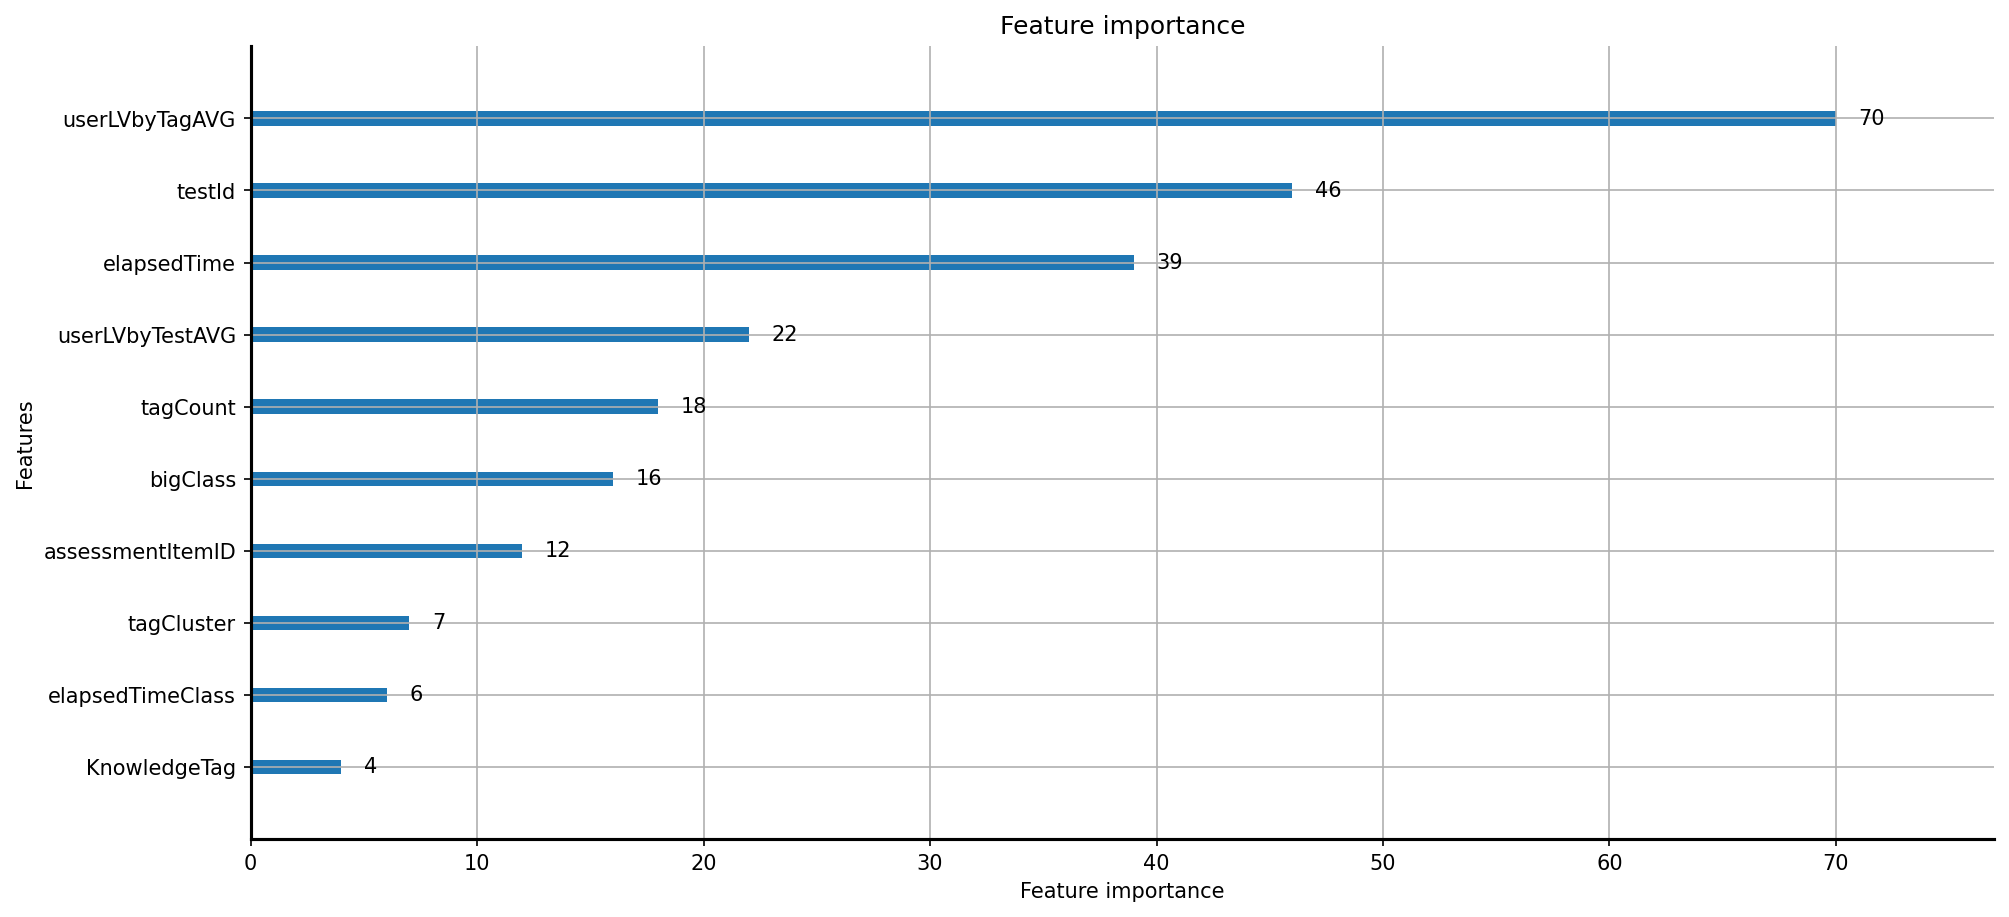

<IPython.core.display.Javascript object>

In [14]:
# INSTALL MATPLOTLIB IN ADVANCE
ax = lgb.plot_importance(model, dpi=150, figsize=(15, 7))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)

### 4-1. Permutation Importance 시각화

In [11]:
perm_imp_df = pd.DataFrame()
perm_imp_df["feature"] = FEATS
perm_imp_df["importance"] = perm.feature_importances_
perm_imp_df["std"] = perm.feature_importances_std_
perm_imp_df.sort_values(by="importance", ascending=False, inplace=True)
perm_imp_df.reset_index(drop=True, inplace=True)
perm_imp_df

,feature,importance,std
0,elapsedTime,0.053849,0.0
1,testId,0.042961,0.0
2,userLVbyTagAVG,0.031024,0.0
3,bigClass,0.019056,0.0
4,elapsedTimeClass,0.011102,0.0
5,assessmentItemID,0.005536,0.0
6,tagCluster,0.004931,0.0
7,KnowledgeTag,0.000544,0.0
8,tagCount,0.000300,0.0
9,day,0.000000,0.0


<IPython.core.display.Javascript object>

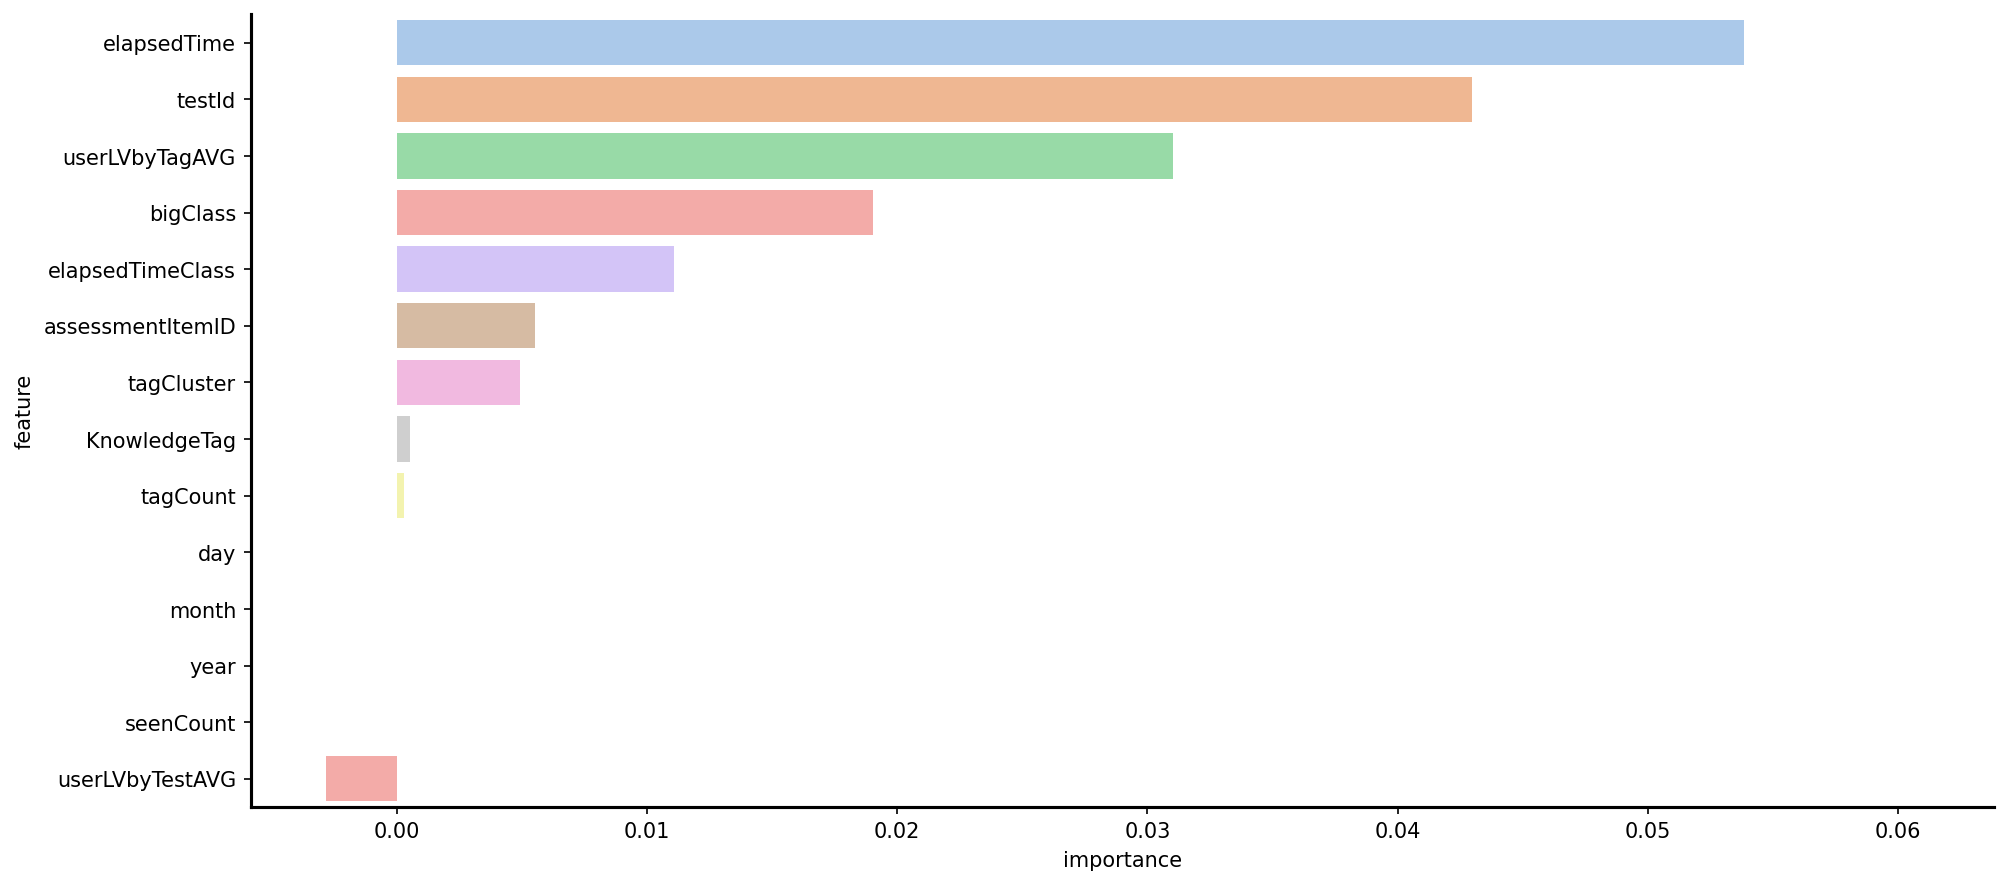

<IPython.core.display.Javascript object>

In [12]:
plt.rcParams["figure.dpi"] = 150  # 고해상도 설정

permutaion_importace = plt.figure(figsize=(15, 7))
ax = permutaion_importace.add_subplot()

ax.set_xlim(
    min(perm_imp_df["importance"]) - 0.003, max(perm_imp_df["importance"]) + 0.01
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)

sns.barplot(x="importance", y="feature", data=perm_imp_df, palette="pastel")
plt.show()

### 4-2. Inferece by test [-2] (test dataset 뒤에서 두번째 값으로 성능 측정)

- option1으로 데이터를 분할했을 때만 유의미함!

In [15]:
# use test dataset only for valid
test = df[(df.dataset == 2) & (df.answerCode != -1)]  # -1 인 answerCode 제외

# test데이터셋은 각 유저의 마지막 interaction만 추출
test = test[test["userID"] != test["userID"].shift(-1)]

y_test = test["answerCode"]
test = test.drop(["answerCode"], axis=1)

preds = model.predict_proba(test[FEATS])[:, 1]
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f"VALID AUC : {auc} ACC : {acc}\n")

VALID AUC : 0.7521012706378061 ACC : 0.6505376344086021



<IPython.core.display.Javascript object>

## 5. Inference

In [ ]:
test_df = df[df.dataset == 2]

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df["userID"] != test_df["userID"].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(["answerCode"], axis=1)

<IPython.core.display.Javascript object>

In [ ]:
# MAKE PREDICTION
total_preds = model.predict_proba(test_df[FEATS])[:, 1]

<IPython.core.display.Javascript object>

In [ ]:
# SAVE OUTPUT
output_dir = "output/"
write_path = os.path.join(output_dir, "submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write("{},{}\n".format(id, p))

writing prediction : output/submission.csv


<IPython.core.display.Javascript object>